# Reddit Vaccine Myth Sentiment Analysis

## Introduction

According to the description of this dataset, r/VaccineMyths is a subreddit where myths related to various vaccines are discussed.

It contains both posts and comments.
The sturcture of this dataset can be understood by these fields:
- title - relevant for posts
- score - relevant for posts - based on impact, number of comments
- id - unique id for posts/comments
- url - relevant for posts - url of post thread
- commns_num - relevant for post - number of comments to this post
- created - date of creation
- body - relevant for posts/comments - text of the post or comment
- timestamp - timestamp

Our task is to perform sentiment analysis and then topic modeling on this dataset.
The topic modeling will be particularly helpful for the medical study of this dataset, because it will let us better understand what are the factors that are related to the originating of particular types of myths surrouding the vaccines.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
dataset_path = os.path.join(dirname, filenames[0])

/kaggle/input/reddit-vaccine-myths/reddit_vm.csv


In [2]:
# Class for decorated printing
# Source: https://stackoverflow.com/a/17303428
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [3]:
# Read data
df = pd.read_csv(dataset_path)
# Print top 5 rows
df.head()

,title,score,id,url,comms_num,created,body,timestamp
0,Health Canada approves AstraZeneca COVID-19 va...,7,lt74vw,https://www.canadaforums.ca/2021/02/health-can...,0,1.614400e+09,NaN,2021-02-27 06:33:45
1,COVID-19 in Canada: 'Vaccination passports' a ...,2,lsh0ij,https://www.canadaforums.ca/2021/02/covid-19-i...,1,1.614316e+09,NaN,2021-02-26 07:11:07
2,Coronavirus variants could fuel Canada's third...,6,lohlle,https://www.canadaforums.ca/2021/02/coronaviru...,0,1.613887e+09,NaN,2021-02-21 07:50:08
3,Canadian government to extend COVID-19 emergen...,1,lnptv8,https://www.canadaforums.ca/2021/02/canadian-g...,0,1.613796e+09,NaN,2021-02-20 06:35:13
4,Canada: Pfizer is 'extremely committed' to mee...,6,lkslm6,https://www.canadaforums.ca/2021/02/canada-pfi...,0,1.613468e+09,NaN,2021-02-16 11:36:28


### Exploratory Data Analysis

I have written some reusable utility functions for the EDA

In [4]:
# Shape of dataset
print(f'Shape of dataset: {df.shape}')

Shape of dataset: (1585, 8)


In [5]:
def basic_information(df):
    print(color.PURPLE + color.BOLD + 'Description: \n' + color.END)
    display(df.describe())
    print(color.PURPLE + color.BOLD + '\nInformation: \n' + color.END)
    display(df.info())
    print(color.PURPLE + color.BOLD + '\nNaN Values: \n' + color.END)
    display(pd.isna(df).sum())
    print(color.PURPLE + color.BOLD + '\nDuplicate rows: \n' + color.END)
    # display(df.duplicated().value_counts())
    display(df[df.duplicated()])

In [6]:
def feature_type(df):
    '''
    This function finds which features in given dataframe 
    are of categorical type and which are numerical
    
    Input - df:Dataframe
    Output - categorical_features:list, numerical_features:list 
    '''
    categorical_features = []
    numerical_features = []
    
    for column in df.columns:
        if df[column].dtype == object:
            categorical_features.append(column)
        else:
            numerical_features.append(column)
            
    return categorical_features, numerical_features

In [7]:
basic_information(df)

Description: 



,score,comms_num,created
count,1585.000000,1585.000000,1.585000e+03
mean,3.686435,1.851735,1.546237e+09
std,30.027315,16.221715,7.076341e+07
min,-12.000000,0.000000,1.389595e+09
25%,1.000000,0.000000,1.554325e+09
50%,1.000000,0.000000,1.569120e+09
75%,3.000000,1.000000,1.583789e+09
max,1185.000000,596.000000,1.631878e+09



Information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1585 entries, 0 to 1584
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      1585 non-null   object 
 1   score      1585 non-null   int64  
 2   id         1585 non-null   object 
 3   url        464 non-null    object 
 4   comms_num  1585 non-null   int64  
 5   created    1585 non-null   float64
 6   body       1213 non-null   object 
 7   timestamp  1585 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 99.2+ KB


None


NaN Values: 



title           0
score           0
id              0
url          1121
comms_num       0
created         0
body          372
timestamp       0
dtype: int64


Duplicate rows: 



,title,score,id,url,comms_num,created,body,timestamp


In [8]:
categorical_features, numerical_features = feature_type(df)
print(color.PURPLE + color.BOLD + 'Categorical Features: ' + color.END + f'{categorical_features}')
print(color.PURPLE + color.BOLD + 'Categorical Features: ' + color.END + f'{categorical_features}')

Categorical Features: ['title', 'id', 'url', 'body', 'timestamp']
Categorical Features: ['title', 'id', 'url', 'body', 'timestamp']


From here, we can see the basic statistical details of the dataset
We can observe that the columns **url** and **body** contain null data.
Also the dataset contains categorical as well as numerical features.

## Visualizing patterns in the occurrence of missing values

Here we would like to see if there is some pattern in the occurrence of the missing values of a column or not. For eg. Are missing values sparsely localted all over the domain, or just located together somewhere specifically as a chunk.

With a heatmap, we would also be able to observe if there is any positive or negative co-occurrence relation between missing values of different columns.

Text(0.5, 1.0, 'Heatmap of missing data pattern')

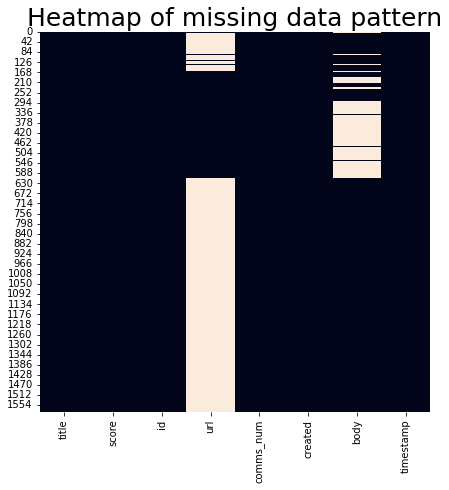

In [9]:
# Visualizing patterns in the occurrence of missing values
plt.figure(figsize=(7,7))
sns.heatmap(df.isna(), cbar=False)
plt.title("Heatmap of missing data pattern", fontsize=25)

We can observe that for url column, there is a bulk absence of values for a part of the domain. Also, there is somewhat a negative correlation between the missing values of **url** and those of **body**, meaning missing values are present for the part fo domain in **body**, where they are present for **url** and vice-versa.

In [10]:
# Creating month and year indices with the timestamp data of the dataset
df['year'] = pd.DatetimeIndex(df['timestamp']).year
df['month'] = pd.DatetimeIndex(df['timestamp']).month

Text(0.5, 1.0, 'Monthwise count every year')

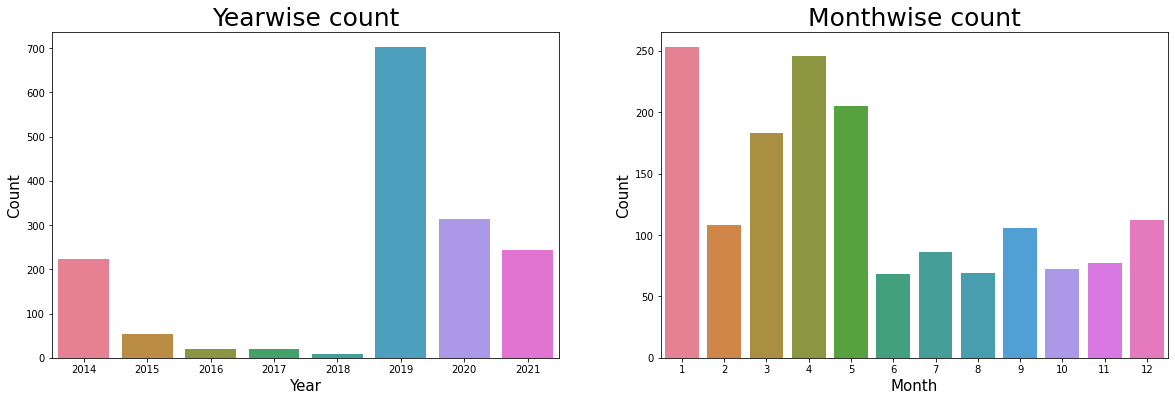

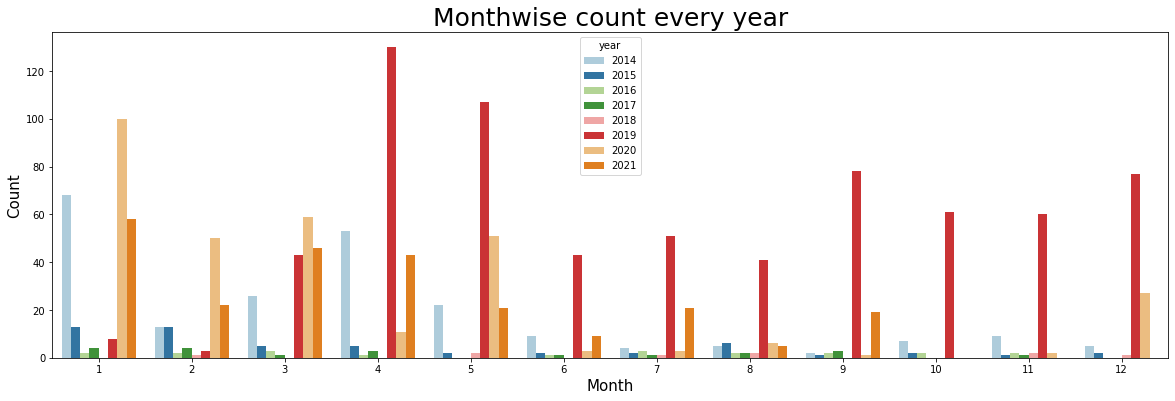

In [11]:
# Count plots
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
sns.countplot(x='year', data=df, palette='husl')
plt.xlabel("Year", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Yearwise count", fontsize=25)

plt.subplot(1,2,2)
sns.countplot(x='month', data=df, palette='husl')
plt.xlabel("Month", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Monthwise count", fontsize=25)

plt.figure(figsize=(20,6))
sns.countplot(x='month', data=df, hue='year', palette='Paired')
plt.xlabel("Month", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Monthwise count every year", fontsize=25)

**Important Findings:**
- Highest number of articles were published in the year 2020, and lowest in 2019
- Highest number of articles monthwise were published in the month

Text(0.5, 1.0, 'Heatmap of co-occurrence matrix')

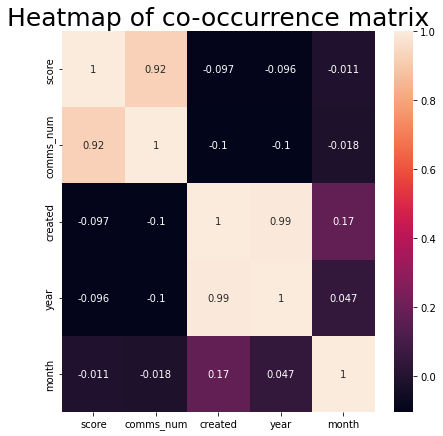

In [12]:
plt.figure(figsize=(7,7))
sns.heatmap(df.corr(method='pearson'), annot=True)
plt.title("Heatmap of co-occurrence matrix", fontsize=25)

We can see there is a high correlation between **year** and **created**, and **comms_num** and **score**, so one column can be dropped in each pair

In [13]:
df.drop(labels=['created', 'comms_num', 'url', 'id', 'timestamp'], axis=1, inplace=True)
df.head()

,title,score,body,year,month
0,Health Canada approves AstraZeneca COVID-19 va...,7,NaN,2021,2
1,COVID-19 in Canada: 'Vaccination passports' a ...,2,NaN,2021,2
2,Coronavirus variants could fuel Canada's third...,6,NaN,2021,2
3,Canadian government to extend COVID-19 emergen...,1,NaN,2021,2
4,Canada: Pfizer is 'extremely committed' to mee...,6,NaN,2021,2


1. Here we dropped the columns created and id because they were not serving any important purpose.  
2. We dropped comms_num since it was highly correlated with score.  
3. We dropped timestamp, since we already extracted year and date from it.  
4. Also, since the column url is more than 50% missing values, we dropped it as well.  


### Data pre-processing 
#### Steps: 
- Tokenzation 
- Stop words 
- Lemmatization 
- Stemming 

Also, it's worth noting that these are reddit posts, so the language is going to be informal.

In [14]:
# Import libraries for pre-processing
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.chunk import RegexpParser

In [15]:
#removing 'nan' values and rows which are empty
index = []
df.replace(np.nan, '', inplace=True)

In [16]:
# Combine title and body together in a column for further ease in processing and analysis
df['text'] = df['title'] + df['body']
df.head()

,title,score,body,year,month,text
0,Health Canada approves AstraZeneca COVID-19 va...,7,,2021,2,Health Canada approves AstraZeneca COVID-19 va...
1,COVID-19 in Canada: 'Vaccination passports' a ...,2,,2021,2,COVID-19 in Canada: 'Vaccination passports' a ...
2,Coronavirus variants could fuel Canada's third...,6,,2021,2,Coronavirus variants could fuel Canada's third...
3,Canadian government to extend COVID-19 emergen...,1,,2021,2,Canadian government to extend COVID-19 emergen...
4,Canada: Pfizer is 'extremely committed' to mee...,6,,2021,2,Canada: Pfizer is 'extremely committed' to mee...


In [17]:
# Convert to lowercase
df['text'] = df['text'].apply(lambda text : " ".join(word.lower() for word in text.split(" ")))

In [18]:
# Remove stop words
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda text : " ".join(word for word in text.split(" ") if word not in stop_words))